# Parsley? Or Dill?

At least once in a lifetime, you’re sent by mom to buy parsley and end up coming home with dill instead (or vice versa). <br>
In this project, we’ll build a model that helps distinguish between these two herbs. <br>
First, we’ll download image data of both plants using the DuckDuckGo search engine. <br>
Next, we’ll train a Convolutional Neural Network (CNN) model based on the gathered images and evaluate its performance. <br>
Finally, we’ll load our own photo and get information on which herb we’re dealing with.


### Downloading Images

To download images of dill and parsley, we’ll use the DuckDuckGo Search library. <br>
Unlike Google, it allows us to download images without using an API key or logging in.


In [1]:
from duckduckgo_search import DDGS        # image searching
import requests                           # downloading images from internet
import os                                 # creating folders and file operations
from PIL import Image                     # working with files
from io import BytesIO                    # reading file without saving on drive
import matplotlib.pyplot as plt           # plotting images
import math

Let’s create a function for downloading images, which will place them in separate folders:


In [2]:
def download_images(query, folder, max_results=100):
    os.makedirs(folder, exist_ok=True)
    results = DDGS().images(query, max_results=max_results, size='Large')
    for i, result in enumerate(results):
        try:
            img_url = result['image']
            response = requests.get(img_url, timeout=10)
            img = Image.open(BytesIO(response.content))
            img.verify()
            img_path = os.path.join(folder, f"{query.replace(' ', '_')}_{i}.jpg")
            with open(img_path, 'wb') as f:
                f.write(response.content)
        except Exception as e:
            print(f"Error while dowloading {img_url}: {e}")

Now let’s try using the function. <br>
To get the most relevant results, we’ll search for the plants using the terms `parsley leaves` and `fresh dill`.<br>
We’ll download 100 high-quality images (`max_results=100`, `size='Large'`) of each plant, which will be placed into their respective folders.


In [3]:
download_images("parsley leaves", "dataset/parsley")
download_images("fresh dill", "dataset/dill")

Error while dowloading http://www.publicdomainpictures.net/pictures/40000/velka/flat-leaf-parsley.jpg: cannot identify image file <_io.BytesIO object at 0x00000287F64ACE00>
Error while dowloading https://familystylefood.com/wp-content/uploads/2022/10/italian-parsley.jpg: cannot identify image file <_io.BytesIO object at 0x00000287F64ACE00>
Error while dowloading https://fichiers.scentree.co/static/scentree_detailed_pages/images/Parsley+Leaf+EO.jpg: cannot identify image file <_io.BytesIO object at 0x00000287F64AC9F0>
Error while dowloading http://www.erinnudi.com/wp-content/uploads/2014/08/parsley-261039_1920.jpg: cannot identify image file <_io.BytesIO object at 0x00000287F64ACE00>
Error while dowloading https://www.gardenerreport.com/wp-content/uploads/2020/09/0_InShot_20200911_155403143-1.jpg: cannot identify image file <_io.BytesIO object at 0x00000287F64F75B0>
Error while dowloading https://familystylefood.com/wp-content/uploads/2022/10/parsley-leaves-washing.jpg: cannot identify 

Let’s check if the downloaded `.jpg` files actually contain images of dill and parsley:<br>

In [4]:
def show_images(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    plt.figure(figsize=(15, 5))

    for i in range(3):
        img_path = os.path.join(folder_path, image_files[i])
        img = Image.open(img_path)

        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.title(image_files[i], fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

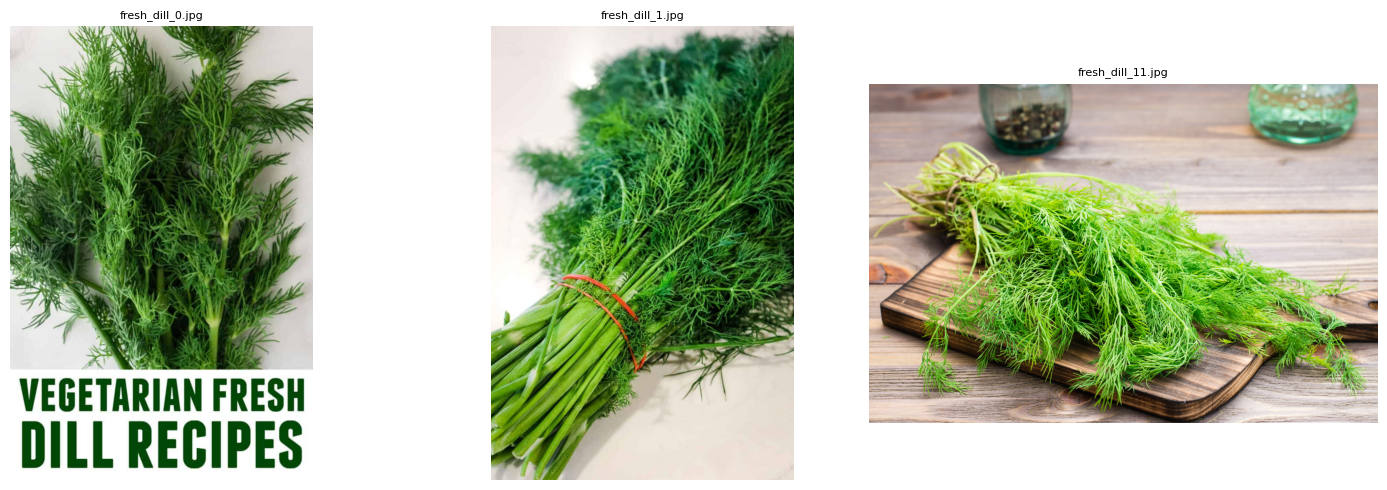

In [5]:
show_images('dataset/dill')

The dill images look good. <br>
Now let’s take a look at the parsley:

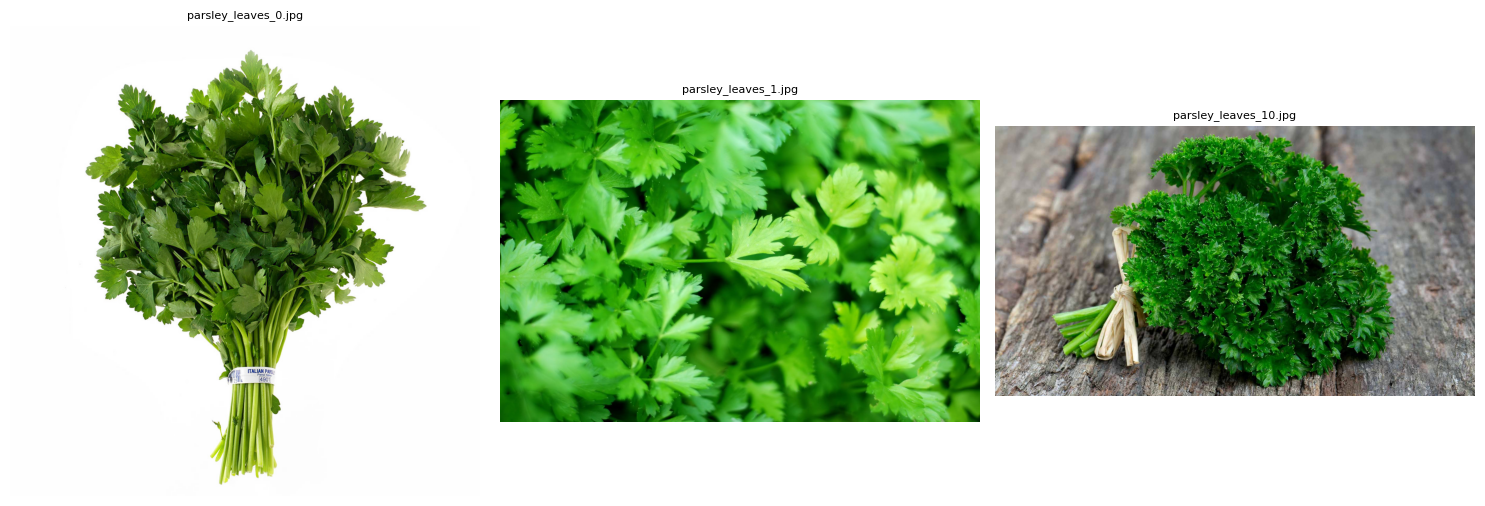

In [6]:
show_images('dataset/parsley')

It looks like the dataset is ready!


### Convolutional Neural Network (CNN) Model


Having downloaded the images in the 'dataset' folder, let's get started on building the Convolutional Neural Network (CNN) model.<br>
We begin by importing the necessary libraries:


In [7]:
from torchvision import models, datasets, transforms  # loading images from folders, transforming images (size, normalization) to tensor format
from torch.utils.data import DataLoader, random_split # splittng data for train and test set
import torch                                          # main library for tensor operations
import torch.nn as nn                                 # module for layers
import torch.optim as optim                           # module for optimizers

Let’s create a function to transform and split the data into appropriate sets. <br>
We resize all images to **224×224**, which is the standard size used by models like ResNet. <br>
Next, we convert the images into [tensors](https://www.tensorflow.org/guide/tensor). <br>
A tensor is a multi-dimensional array of a single data type, similar to NumPy arrays but immutable—it's the required format for PyTorch. <br>
Finally, we normalize the images to help the model learn faster. <br>
We’ll split the dataset into training, validation, and test sets in a **7:2:1** ratio. <br>
The validation set is helpful for evaluating the model during training and tuning its hyperparameters. <br>
The function returns the training, validation, and test datasets, along with the class names. <br>
Class names are useful for mapping the numerical indices (used internally by the model) back to their corresponding labels.


In [8]:
def prepare_data(data_dir="dataset", train_ratio=0.7, val_ratio=0.2):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    class_names = full_dataset.classes
    print(f"Klasy: {class_names}")

    train_size = math.floor(train_ratio * len(full_dataset))
    val_size = math.floor(val_ratio * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
    return train_dataset, val_dataset, test_dataset, class_names

Almost ready to train the model!<br>
For loading our images into the model we use a `DataLoader()`. <br>
To improve efficiency, let's use **batch processing**.<br>
Next, we’ll load a pretrained **ResNet18** model. <br>
We’ll replace the final layer of the model with a linear one to match the number of classes in our dataset. <br>
Then, we define a **loss function** (`CrossEntropyLoss`) and an **optimizer** (`Adam`). <br>
The loss function is a measure of the model’s error, which gets minimized during training. <br>
The optimizer updates the model’s weights to reduce this loss. <br>
Finally, we define a **training loop** that will run for 100 epochs. <br>
In each epoch, the model learns from both the training and validation sets. <br>
If the model doesn’t improve for 5 consecutive epochs, we stop training early (**early stopping**) and load best model.<br>
Loss and accuracy values will be printed to the console.


In [9]:
train_dataset, val_dataset, test_dataset, class_names = prepare_data()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load a pre-trained ResNet model
model = models.resnet18(weights='DEFAULT')

# Replace the final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Save the best model during training
best_model_path = 'best_model.pth'

for epoch in range(num_epochs):
    if early_stop:
        print("Early stopping")
        break

    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), best_model_path)
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        early_stop = True

Klasy: ['dill', 'parsley']


C:\Users\ptakm\PycharmProjects\parsley-or-dill\.venv\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/100, Loss: 0.6092
Validation Loss: 5.7056
Epoch 2/100, Loss: 0.5022
Validation Loss: 3.4007
Epoch 3/100, Loss: 0.2327
Validation Loss: 0.3058
Epoch 4/100, Loss: 0.1878
Validation Loss: 1.2411
Epoch 5/100, Loss: 0.0899
Validation Loss: 0.3157
Epoch 6/100, Loss: 0.0848
Validation Loss: 0.3437
Epoch 7/100, Loss: 0.1337
Validation Loss: 0.3861
Epoch 8/100, Loss: 0.1052
Validation Loss: 0.1620
Epoch 9/100, Loss: 0.0380
Validation Loss: 0.3097
Epoch 10/100, Loss: 0.0144
Validation Loss: 0.1766
Epoch 11/100, Loss: 0.0260
Validation Loss: 0.1439
Epoch 12/100, Loss: 0.0067
Validation Loss: 0.1441
Epoch 13/100, Loss: 0.0058
Validation Loss: 0.1664
Epoch 14/100, Loss: 0.0107
Validation Loss: 0.4445
Epoch 15/100, Loss: 0.0475
Validation Loss: 1.8862
Epoch 16/100, Loss: 0.0996
Validation Loss: 0.7041
Early stopping


Training was completed at epoch 13. <br>
This means the best performance was achieved at epoch 9. <br>
After finishing training, the model was saved to disk. <br>
Let’s load it and evaluate how well it performs on the **test set**.



In [10]:
# Load the best model after training
model.load_state_dict(torch.load(best_model_path))

# Evaluate the model on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

validation_accuracy = 100 * correct / total
print(f"Test Accuracy: {validation_accuracy:.2f}%")

Test Accuracy: 100.00%


We’ve achieved an accuracy of **100.00%** on the test set! <br>
Let’s verify that the model works correctly. <br>
We’ll load an image of **dill** and **parsley** to see if the model classifies them properly. <br>
To do this, we’ll create a function that loads an image, transforms it into the format expected by the model, and outputs the result. <br>
Finally, the image and its predicted label will be displayed.


In [11]:
def predict_image(image_path, model, class_names, device):
    # Define the transformation for the input image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Apply the transformation
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Set the model to evaluation mode
    model.eval()

    # Make the prediction
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        predicted_label = class_names[predicted.item()]

    # Display the image and prediction
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

    return predicted_label

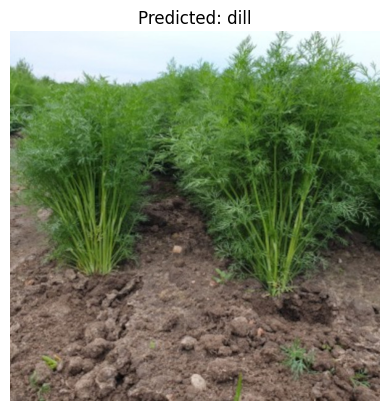

Predicted label: dill


In [12]:
image_path = 'dill-photo.jpg'
predicted_label = predict_image(image_path, model, class_names, device)
print(f"Predicted label: {predicted_label}")

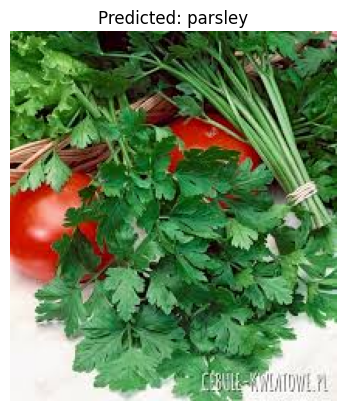

Predicted label: parsley


In [13]:
image_path = 'parsley-photo.jpg'
predicted_label = predict_image(image_path, model, class_names, device)
print(f"Predicted label: {predicted_label}")

As we can see, both images were correctly identified!<br>
We’ll never come back home with dill instead of parsley (or the other way around) again!


### Conclusions

Although the topic explored in this project has a somewhat humorous undertone, the tools and methods presented can be applied in more serious contexts - for instance, in medicine.<br>
We used them to recognize herbs, but the very same methods could be used to classify lung diseases based on X-ray images!